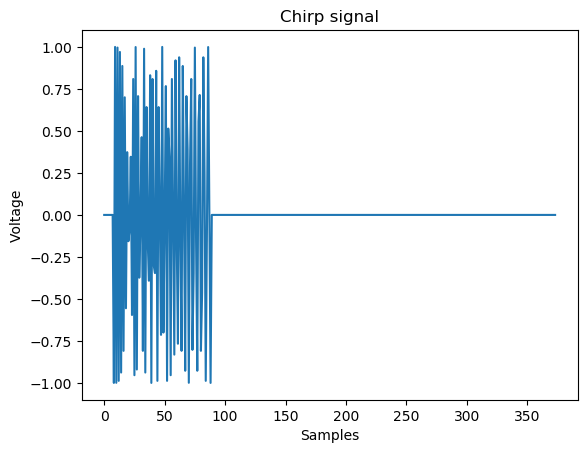

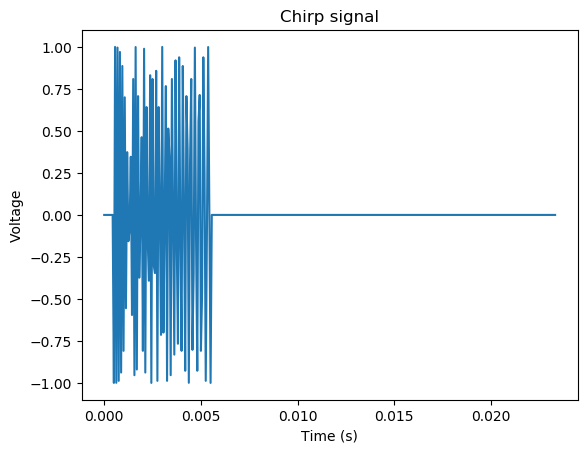

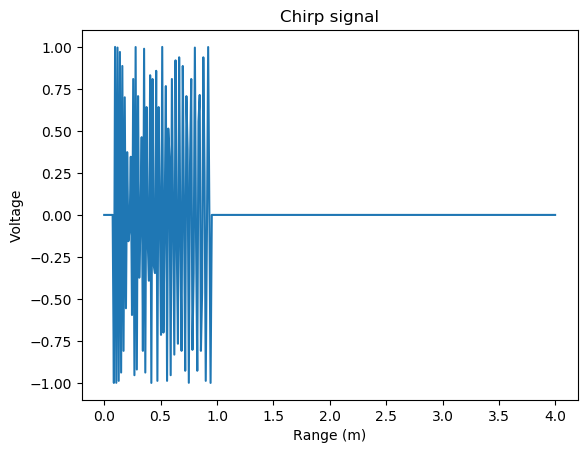

In [93]:
#STEP 1: Chirp pulse creation

c = 343;  # Speed of sound in air in m/s
B = 4000; # Chirp bandwidth
fs = 4*B; # This is the sample rate of the sonar.
dt = 1/fs; # This is the sample spacing
r_max = 4; # Maximum range in metres to which to simulate.
t_max = 2*r_max/c; # Time delay to max range

# Create an array containing the time values of the samples
t = collect(0:dt:t_max); # t=0:dt:t_max defines a “range”.
# Create an array containing the range values of the samples
r = c*t/2;
# NOW create the chirp pulse, shifted by an amount td, to start at
# some time td-T/2>0.
f0 = 10000; # Centre frequency is 10 kHz
T = 5E-3; # Chirp pulse length
K = B/T; # Chirp rate
# Define a simple a rect() function which returns for -0.5<=t<=0.5 or 0.
# The function will work if t is an array of values.
rect(t) = (abs.(t) .<= 0.5)*1.0
# rect(t/T) spans the interval [-T/2,T/2]
# We must therefore delay the chirp pulse so that it starts after t=0.
# Shift the chirp pulse by 0.6T units to the right, so that it starts at
0.1*T
td = 0.6*T; # Chirp delay
# Note: one can use the macro “@.” to avoid having to put “.” for arrays:
# @. v_tx = cos( 2*pi*(f0*(t-td) + 0.5*K*(t-td).^2) ).*rect((t-td)/T);
v_tx = cos.( 2*pi*(f0*(t .- td) + 0.5*K*(t .- td).^2) ) .* rect.((t .-td)/T);


using PyPlot; pygui(false) # import plot library
# If not installed, add the package via: using Pkg; Pkg.add("PyPlot");
figure() # Create a new figure
plot(v_tx) # Basic plot, axis labeled in samples
title("Chirp signal")
xlabel("Samples");
ylabel("Voltage");

figure() # Create a new figure
plot(t,v_tx) # Put time on x-axis
title("Chirp signal")
xlabel("Time (s)");
ylabel("Voltage");

figure() # Create a new figure
plot(r,v_tx) # Put range on x-axis
title("Chirp signal")
xlabel("Range (m)");
ylabel("Voltage");


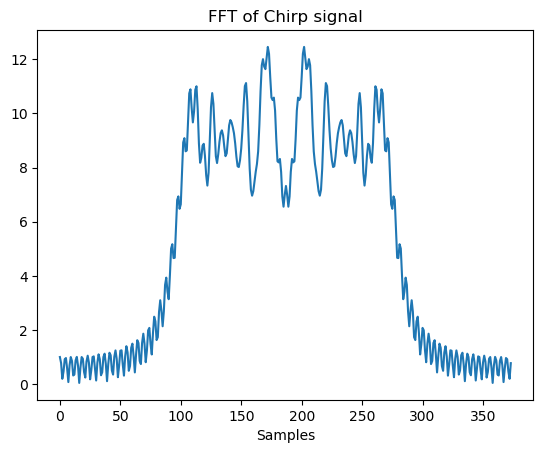

In [94]:
using FFTW # If not installed do: using Pkg; Pkg.add("FFTW");

V_TX = fft(v_tx); 
figure()
plot( abs.(V_TX) )
title("FFT of Chirp signal");
xlabel("Samples");

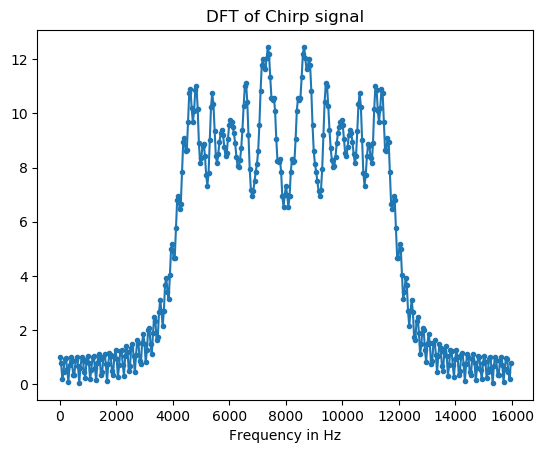

In [95]:
#LABEL frequency axis
N = length(t);
Δf = 1/(N*dt) # spacing in frequency domain
#create array of freq values stored in f_axis. First element maps to 0Hz
f_axis = (0:N-1)*Δf;
figure();
plot(f_axis, abs.(V_TX),".-");
title("DFT of Chirp signal");
xlabel("Frequency in Hz");

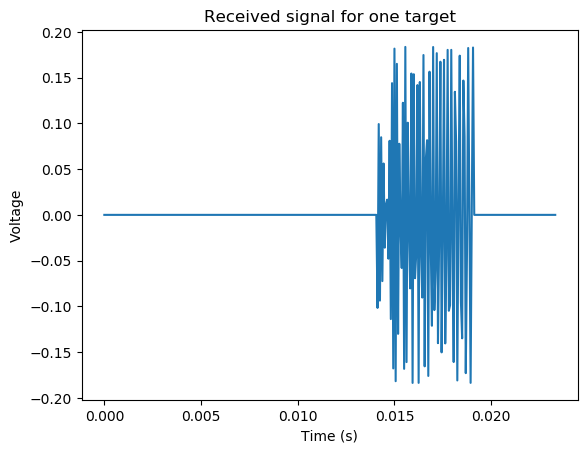

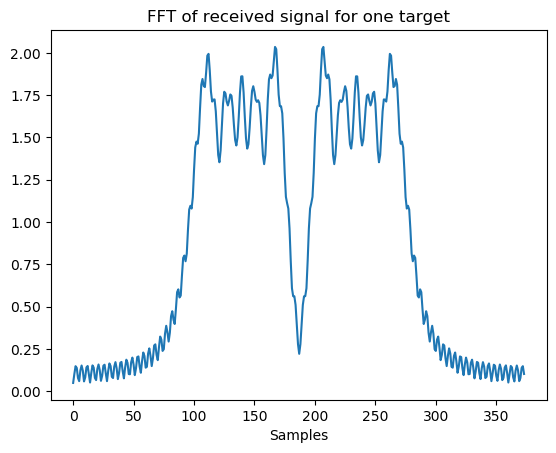

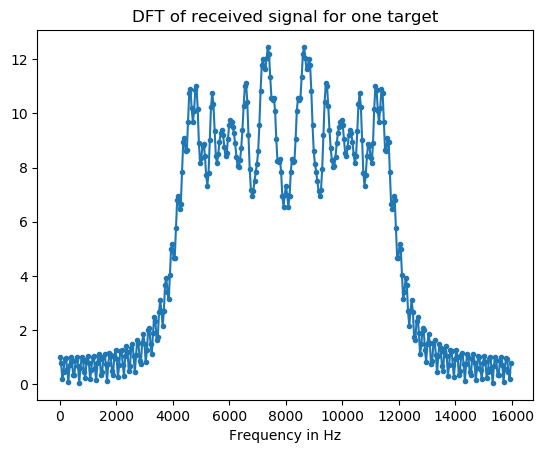

In [96]:
#STEP 2: Point target simulation

R1 = 1.5 + (12-2)/12 # 2.33m - range to target.
td1 = 2*R1/c; # two way delay to target.
A1 = 1/R1^2; # echo voltage signal proportional to 1/R^2
v_rx = A1*cos.( 2*pi*(f0*(t.-td.-td1) + 0.5*K*(t.-td.-td1).^2) ) .* rect((t.-
td.-td1)/T); 

V_RX = fft(v_rx);

figure() # Create a new figure
plot(t,v_rx) # Put time on x-axis
title("Received signal for one target")
xlabel("Time (s)");
ylabel("Voltage");

figure() # Create a new figure
plot(abs.(V_RX) )
title("FFT of received signal for one target");
xlabel("Samples");

figure();
plot(f_axis, abs.(V_TX),".-");
title("DFT of received signal for one target");
xlabel("Frequency in Hz");

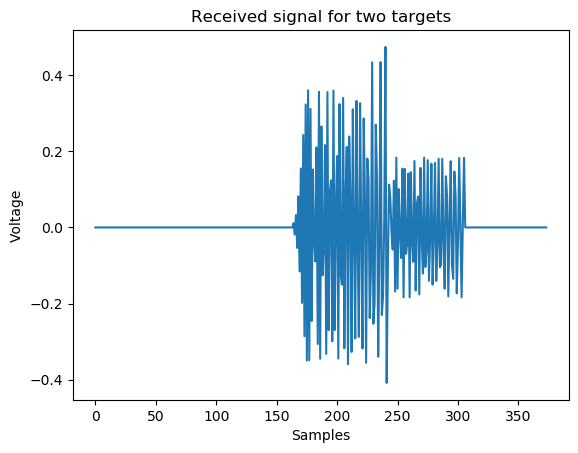

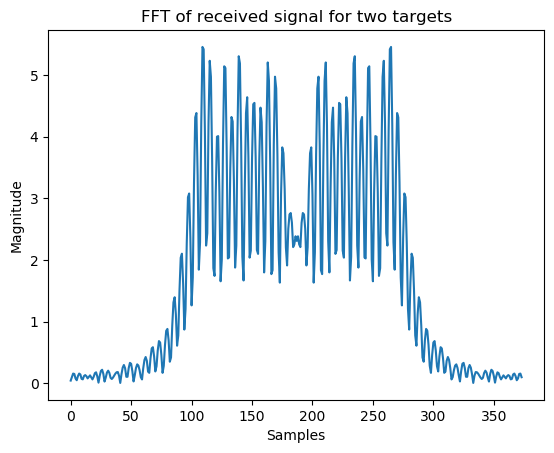

In [97]:
#second target
R2 =  1.5 + (12-10)/12# 1.67m - range to target.
td2 = 2*R2/c; # two way delay to target.
A2 = 1/R2^2; # echo voltage signal proportional to 1/R^2
v_rx = A1*cos.(2*pi*(f0*(t.-td.-td1) + 0.5*K*(t.-td.-td1).^2) ) .* rect((t.-
td.-td1)/T) + A2*cos.(2*pi*(f0*(t.-td.-td2) + 0.5*K*(t.-td.-td2).^2) ) .* rect((t.-
td.-td2)/T);
V_RX = fft(v_rx);

figure() # Create a new figure
plot(v_rx) # Put time on x-axis
title("Received signal for two targets")
xlabel("Samples");
ylabel("Voltage");

figure() # Create a new figure
plot(abs.(V_RX) )
title("FFT of received signal for two targets");
xlabel("Samples");
ylabel("Magnitude");

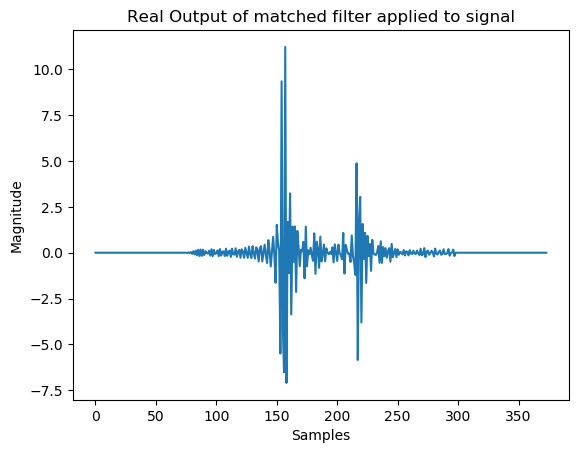

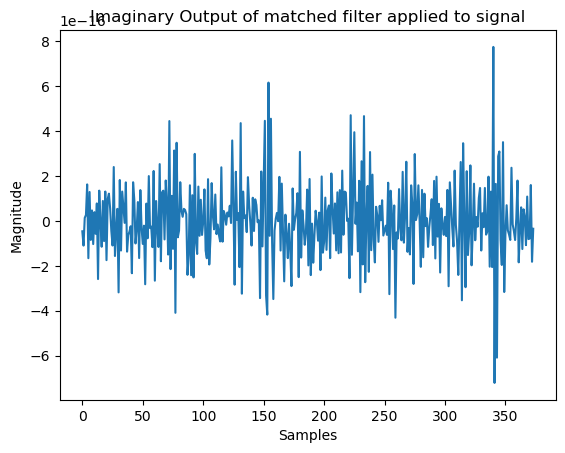

In [98]:
#STEP 3: Matched filtering

H = conj( V_TX);
V_MF = H.*V_RX;
v_mf = ifft(V_MF);

figure() # Create a new figure
plot(real(v_mf));
title("Real Output of matched filter applied to signal")
xlabel("Samples");
ylabel("Magnitude");

figure() # Create a new figure
plot(imag(v_mf));
title("Imaginary Output of matched filter applied to signal")
xlabel("Samples");
ylabel("Magnitude");

#Negligble Imaginary part <1E-14

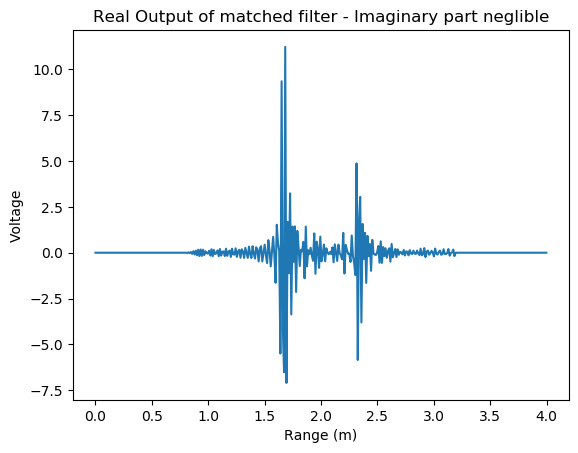

In [99]:
v_mf = real(v_mf);
figure() # Create a new figure
plot(r,v_mf) # To see the detail – zoom in to have a good look.
title("Real Output of matched filter - Imaginary part neglible")
xlabel("Range (m)");
ylabel("Voltage");


# Take note of the shape of the envelope, as well as the internal detail.
# effect of pulse compression

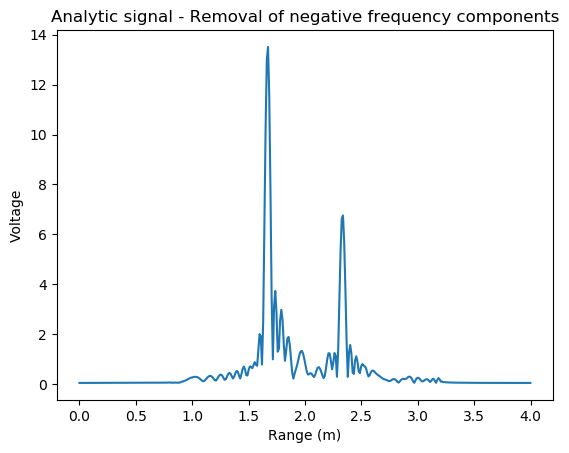

In [100]:
#STEP 4: Forming an analytic signal

V_ANAL = 2*V_MF; # make a copy and double the values
N = length(V_MF);
V_ANAL = 2*V_MF; # make a copy and double the values
N = length(V_MF);
if mod(N,2)==0 # case N even
 neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
 neg_freq_range = Int((N+1)/2):N;
end
V_ANAL[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal = ifft(V_ANAL);

figure() # Create a new figure
plot(r,abs.(v_anal)) # To see the magnitude – zoom in to have a good look.
title("Analytic signal - Removal of negative frequency components")
xlabel("Range (m)");
ylabel("Voltage");

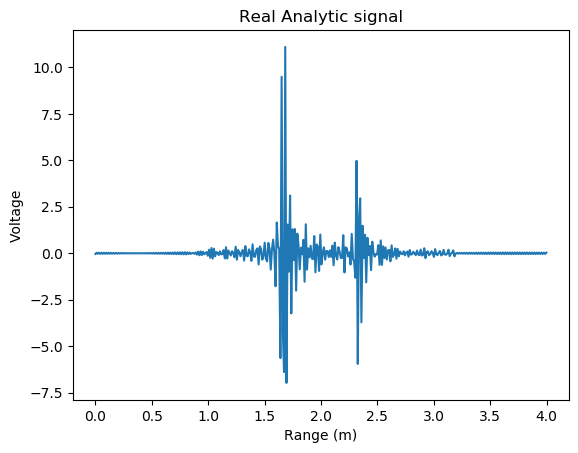

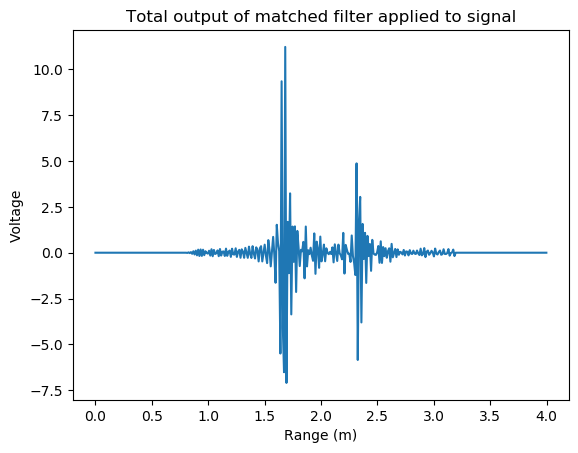

In [101]:
figure() # Create a new figure
plot(r,real(v_anal));  #compare to v_mf
title("Real Analytic signal")
xlabel("Range (m)");
ylabel("Voltage");

figure() # Create a new figure
plot(r,v_mf);
title("Total output of matched filter applied to signal")
xlabel("Range (m)");
ylabel("Voltage");

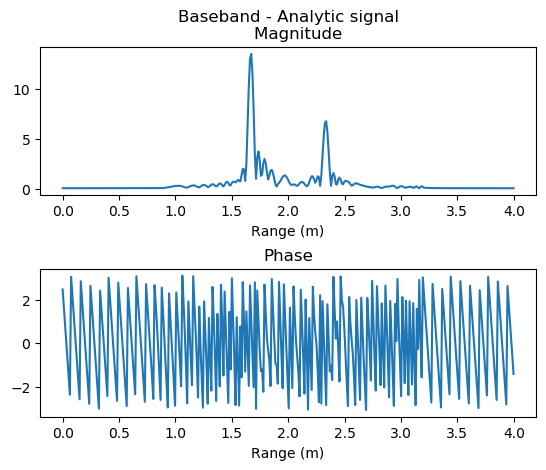

In [102]:
#STEP 5: Translating the signal to baseband

j=im; # Assign j as sqrt(-1) (“im” in julia)
v_bb = v_anal.*exp.(-j*2*pi*f0*t);

fig = figure() # Create a new figure

subplot(2,1,1)
plot(r,abs.(v_bb))
title("Baseband - Analytic signal
    Magnitude")
xlabel("Range (m)");
fig.subplots_adjust(hspace=.5)
subplot(2,1,2)
plot(r,angle.(v_bb))
title("
Phase")
xlabel("Range (m)");


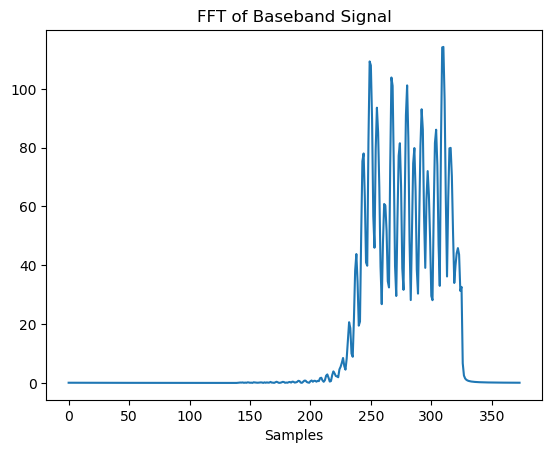

In [103]:
V_BB = fft(v_bb); 
figure() # Create a new figure
plot(abs.(V_BB))
title("FFT of Baseband Signal");
xlabel("Samples");

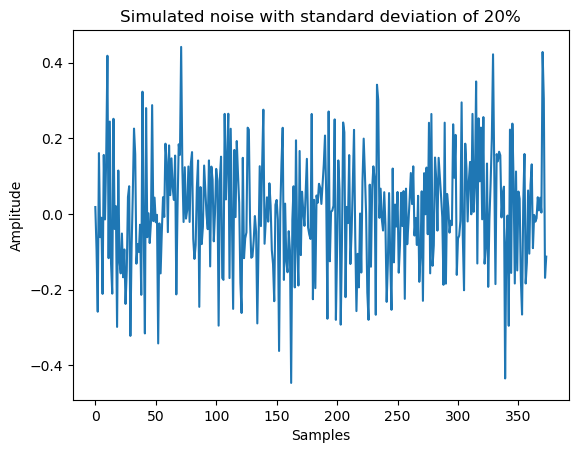

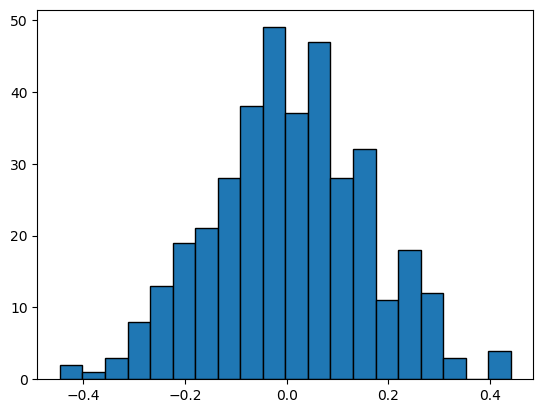

Calculated std dev = 0.15440247708380672


In [104]:
#STEP 6: Adding noise to the simulation

sigma = 0.8 * A1;
noise_signal = sigma * randn(N);
figure() # Create a new figure
plot(noise_signal)
title("Simulated noise with standard deviation of 20%");
xlabel("Samples");
ylabel("Amplitude");

figure() # Create a new figure
nbins=20
hist(noise_signal,nbins,edgecolor = "black")
using Statistics # import basic stats functions
println("Calculated std dev = ", std(noise_signal))



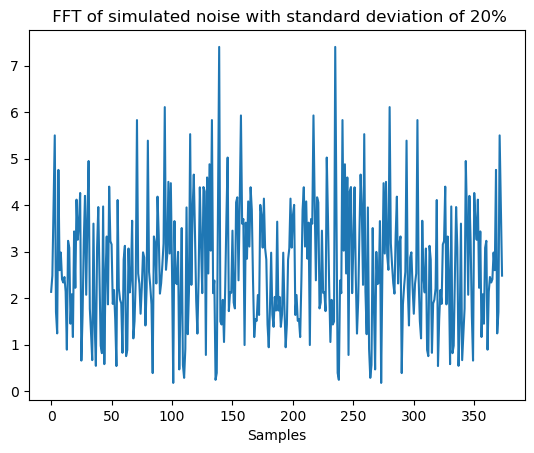

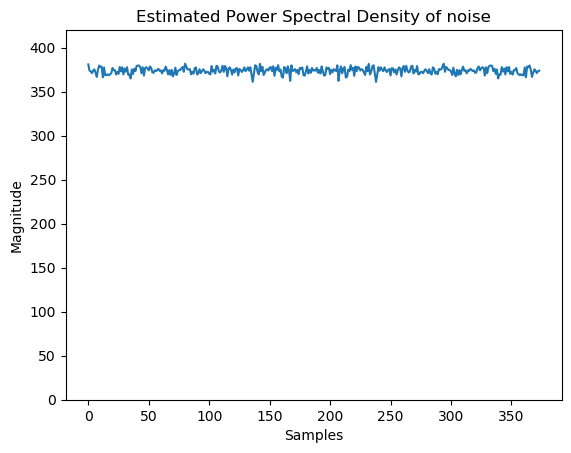

(0.0, 419.78710696152626)

In [105]:
figure() # Create a new figure
NS = fft(noise_signal);
plot(abs.(NS))
title(" FFT of simulated noise with standard deviation of 20%");
xlabel("Samples");

#PSD 

N_ave = 10000; # Try different values of Nave 10, 100, 1000 ...
PSD_sum = zeros(N);
for n=1:N_ave;
global PSD_sum = PSD_sum .+ ( abs.(fft( randn(N) )) ).^2;
end
PSD_estimated = PSD_sum/N_ave;
figure();
plot(PSD_estimated);
title("Estimated Power Spectral Density of noise");
xlabel("Samples");
ylabel("Magnitude");
ylim([0,1.1*maximum(PSD_estimated)])


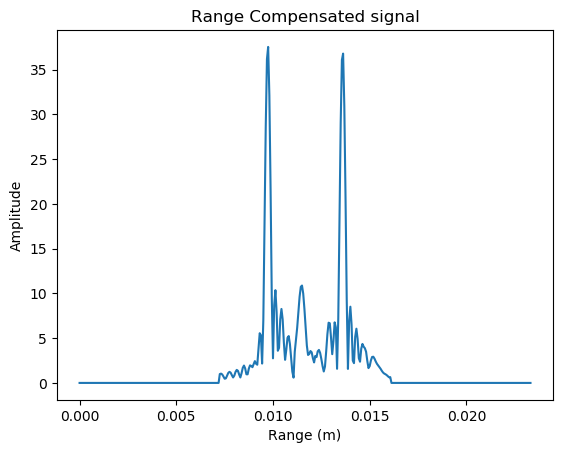

In [106]:
#Part 7

# Define a simple a rect() function which returns for -0.25<=t<=0.25 or 0.
# The function will work if t is an array of values.
rect2(t) = (abs.(t) .<= 0.25)*1.0
R1_func = R1^2 
R2_func = R2^2
v_rc = v_bb.* rect.((t.-td1)/T)*R1_func .+ v_bb.* rect.((t .-td2)/T)*R2_func;

figure() # Create a new figure
plot(t,real(abs.(v_rc)));    
title("Range Compensated signal")
xlabel("Range (m)");
ylabel("Amplitude");

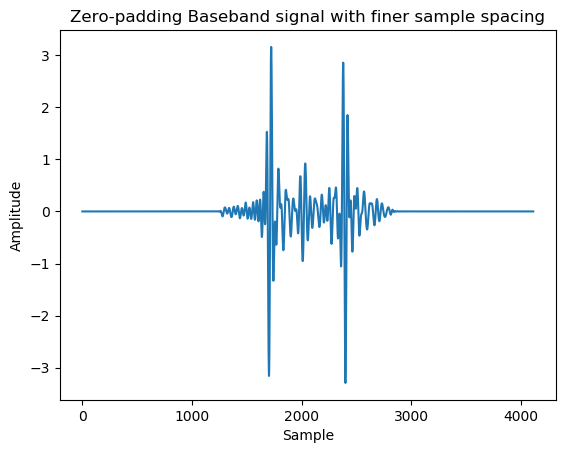

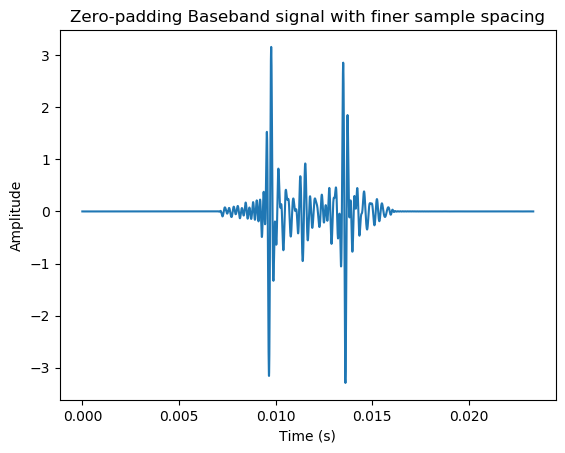

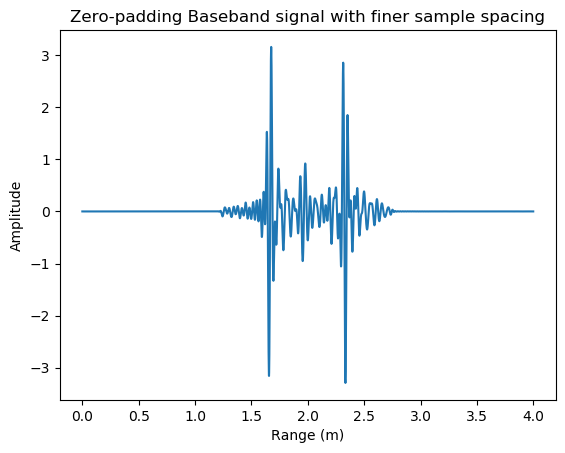

In [109]:
Empty  = zeros(10*N)
p = floor(Int32, N/2)
V_BB_Padded = fft(v_rc)
temp = vcat(V_BB_Padded[1:p-1], Empty)
X = vcat(temp, V_BB_Padded[p:end])
x = ifft(X);
time_new = collect(0:dt/11.022:t_max);
range_new = c*time_new/2;

figure()
plot(x);
title("Zero-padding Baseband signal with finer sample spacing")
xlabel("Sample");
ylabel("Amplitude");

using PyPlot;
figure()
plot(time_new,x);
title("Zero-padding Baseband signal with finer sample spacing")
xlabel("Time (s)");
ylabel("Amplitude");


figure()
plot(range_new,x);
title("Zero-padding Baseband signal with finer sample spacing")
xlabel("Range (m)");
ylabel("Amplitude");